In [15]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Dropout, Conv2d, MaxPool2d
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim import AdamW

import gurobipy as gb
from gurobipy import GRB
import time

### Check if GPU available

In [16]:
# set CUDA_VISIBLE_DEVICES=0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
interval = 5

train_test_dir = os.path.join(os.getcwd(), f"dataGeneration/preprocessed_data_{interval}")

X_train = np.load(os.path.join(train_test_dir, "X_train.npy"))
X_val = np.load(os.path.join(train_test_dir, "X_val.npy"))

y_train = np.load(os.path.join(train_test_dir, "y_train.npy"))
y_val = np.load(os.path.join(train_test_dir, "y_val.npy"))

index_train = np.load(os.path.join(train_test_dir, "indices_train.npy")).astype("int64")
index_val = np.load(os.path.join(train_test_dir, "indices_val.npy")).astype("int64")

solTime_val = np.load(os.path.join(train_test_dir, "solTime_val.npy"))
objVal_val = np.load(os.path.join(train_test_dir, "objVal_val.npy"))
schedule_val = np.load(os.path.join(train_test_dir, "schedule_val.npy")).astype("int32")
model_val = np.load(os.path.join(train_test_dir, "model_val.npy")).astype("int32")


In [18]:
print(X_train.shape, X_val.shape)
print(X_train.dtype)
print(y_train.shape, y_val.shape)
print(y_train.dtype)
print(index_train.shape, index_val.shape)
print(index_train.dtype)

(719, 48, 169) (80, 48, 169)
float64
(719, 767300) (80, 767300)
float64
(719, 767300) (80, 767300)
int64


### Building the CNN network

In [19]:
X_train, X_val = np.transpose(X_train, (0,2,1)), np.transpose(X_val, (0,2,1))
print(X_train.shape, X_val.shape)

in_channels = X_train.shape[1]
col = X_train.shape[2]

out_channels = y_train[0].size

print(in_channels, col, out_channels)

(719, 169, 48) (80, 169, 48)
169 48 767300


In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.hidden_ch = 64
        self.dp = 0.1

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels, self.hidden_ch, 11, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(self.dp),
            nn.MaxPool1d(5, stride=1, padding=0),

            nn.Conv1d(self.hidden_ch, self.hidden_ch*2, 7, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(self.dp),
            nn.MaxPool1d(5, stride=1, padding=0),

            nn.Conv1d(self.hidden_ch*2, self.hidden_ch, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(self.dp),
            nn.MaxPool1d(5, stride=1, padding=0),
        )
        
        n_channels = self.feature_extractor(torch.zeros(1, in_channels, col)).size(-1)

        self.classifier = nn.Sequential(
            nn.MaxPool1d(n_channels), # GAP
            nn.Flatten(),
            nn.Linear(self.hidden_ch, self.hidden_ch*2),
            nn.ReLU(),
            nn.Dropout(self.dp),
            nn.Linear(self.hidden_ch*2, self.hidden_ch*2),
            nn.ReLU(),
            nn.Dropout(self.dp),
            nn.Linear(self.hidden_ch*2, out_channels),
            nn.Sigmoid())


    def forward(self, x):
        features = self.feature_extractor(x)
        out = self.classifier(features)
        return out
        

### Create Dataset and DataLoader

In [21]:
config = {
        'batch_size' : 8, # Num samples to average over for gradient updates
        'EPOCHS' : 150, # Num times to iterate over the entire dataset
        'LEARNING_RATE' : 5e-4, # Learning rate for the optimizer
        'WEIGHT_DECAY' : 1e-4, # Weight decay parameter for the Adam optimizer
    }

In [22]:
class coordinationDataset(TensorDataset):
    def __init__(self, X, y):
        super(coordinationDataset, self).__init__()
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.round(torch.tensor(y, dtype=torch.float32))

        return X_tensor, y_tensor
    
    def __len__(self):
        return len(self.X)

In [23]:
train_dataset = coordinationDataset(X_train, y_train)
val_dataset = coordinationDataset(X_val, y_val)

In [24]:
net = NeuralNetwork()

batch_size = config['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(net.parameters(), lr=config["LEARNING_RATE"])
total_steps = len(train_loader)


#### Define custom loss function

In [25]:
def asymmetric_loss(predict, target, gamma_neg=0.3, gamma_pos=0, clip=0.0, eps=1e-8, disable_torch_grad_focal_loss=True):

    """"
    Parameters
    ----------
    x: input logits
    y: targets (multi-label binarized vector)
    """

    # Calculating Probabilities
    x_sigmoid = predict
    xs_pos = x_sigmoid
    xs_neg = 1 - x_sigmoid

    # Asymmetric Clipping
    if clip is not None and clip > 0:
        xs_neg = (xs_neg + clip).clamp(max=1)

    # Basic CE calculation
    los_pos = target * torch.log(xs_pos.clamp(min=eps))
    los_neg = (1 - target) * torch.log(xs_neg.clamp(min=eps))
    loss = los_pos + los_neg

    # Asymmetric Focusing
    if gamma_neg > 0 or gamma_pos > 0:
        if disable_torch_grad_focal_loss:
            torch.set_grad_enabled(False)
        pt0 = xs_pos * target
        pt1 = xs_neg * (1 - target)  # pt = p if t > 0 else 1-p
        pt = pt0 + pt1
        one_sided_gamma = gamma_pos * target + gamma_neg * (1 - target)
        one_sided_w = torch.pow(1 - pt, one_sided_gamma)
        if disable_torch_grad_focal_loss:
            torch.set_grad_enabled(True)
        loss *= one_sided_w

    return -loss.mean()


In [26]:
net = net.to(device)

### Start of Training Loop

In [27]:
loss_list = []
loss_list_val = []

for epoch in range(config["EPOCHS"]):
    running_loss = 0.0
    running_loss_val = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = net(inputs)

        # loss_fn = nn.BCELoss()     
        loss = asymmetric_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

    for j, data in enumerate(valid_loader):
        net.eval()
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = net(inputs)

        # loss_fn = nn.BCELoss()  
        loss = asymmetric_loss(outputs, labels)
        running_loss_val += loss.item()
    print('Epoch %d val loss: %.3f' % (epoch + 1, running_loss_val / len(valid_loader)))

    if len(loss_list_val) > 0:
        print("min loss: ", min(loss_list_val))
        if (running_loss_val / len(valid_loader)) < min(loss_list_val):
            torch.save(net.state_dict(), os.path.join(os.getcwd(), f"ML_Model/CNN_1D_coordination_{interval}.pth"))
            print("Model saved")
    
    loss_list.append(running_loss / len(train_loader))
    loss_list_val.append(running_loss_val / len(valid_loader))
    
    # if training loss is lower than previous loss, save the model


Epoch 1 loss: 0.146
Epoch 1 val loss: 0.022
Epoch 2 loss: 0.015
Epoch 2 val loss: 0.015
min loss:  0.02185544278472662
Model saved
Epoch 3 loss: 0.014
Epoch 3 val loss: 0.014
min loss:  0.014799443259835243
Model saved
Epoch 4 loss: 0.014
Epoch 4 val loss: 0.014
min loss:  0.014486995339393616
Model saved
Epoch 5 loss: 0.014
Epoch 5 val loss: 0.014
min loss:  0.014416238479316234
Model saved
Epoch 6 loss: 0.014
Epoch 6 val loss: 0.014
min loss:  0.014262507017701865
Epoch 7 loss: 0.014
Epoch 7 val loss: 0.014
min loss:  0.014262507017701865
Epoch 8 loss: 0.014
Epoch 8 val loss: 0.014
min loss:  0.014262507017701865
Model saved
Epoch 9 loss: 0.014
Epoch 9 val loss: 0.014
min loss:  0.014204000681638717
Epoch 10 loss: 0.014
Epoch 10 val loss: 0.014
min loss:  0.014204000681638717
Model saved
Epoch 11 loss: 0.014
Epoch 11 val loss: 0.014
min loss:  0.014135484676808118
Epoch 12 loss: 0.014
Epoch 12 val loss: 0.014
min loss:  0.014135484676808118
Epoch 13 loss: 0.014
Epoch 13 val loss: 0.0

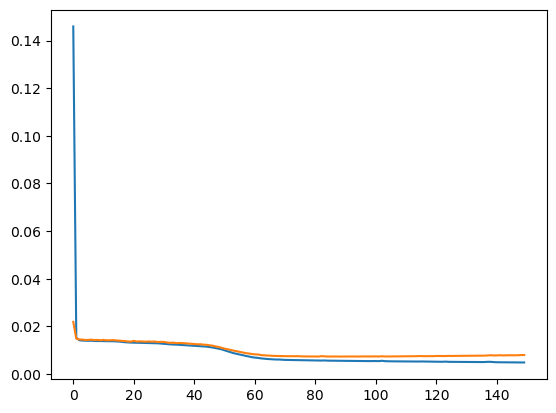

In [28]:
plt.plot(loss_list)
plt.plot(loss_list_val)

### Model Testing

In [ ]:
# load the model
net = NeuralNetwork()
net.load_state_dict(torch.load(os.path.join(os.getcwd(), f"ML_Model/CNN_1D_coordination_{interval}.pth")))

In [ ]:
# test number of feasible solutions
# test the model on the test set
net.eval()
net.to(device)

#### Testing of bit accuracy

In [ ]:
thres = 0.5

one_accuracy = []
zero_accuracy = []
bit_accuracy = []
running_loss = 0
mean_one = []
mean_zero = []

for j, data in enumerate(valid_loader):
    
    net.eval()
    inputs, labels = data

    inputs, labels = inputs.to(device), labels.to(device)       
    optimizer.zero_grad()
    outputs = net(inputs)

    loss_fn = nn.BCELoss()
    loss = loss_fn(outputs, labels)
    running_loss += loss.item()

    # start testing
    outputs = (outputs).reshape(-1,)   
    outputs_percent = outputs
    outputs = torch.where(outputs >= thres, torch.ceil(outputs), torch.floor(outputs)).reshape(-1,)
    # outputs = torch.round(outputs)
    labels = labels.reshape(-1,)

    one_labels = torch.where(labels == 1)
    zero_labels = torch.where(labels == 0)
    
    one_outputs = outputs[one_labels]
    zero_outputs = outputs[zero_labels]

    one_acc = 1 - torch.sum(torch.abs(1 - one_outputs)) / one_outputs.shape[0] # 1 minus percentage of error
    zero_acc = 1 - torch.sum(torch.abs(0 - zero_outputs)) / zero_outputs.shape[0]
    bit_acc = 1 - torch.sum(torch.abs(outputs - labels)) / labels.shape[0]

    one_accuracy.append(one_acc.cpu().detach().numpy())
    zero_accuracy.append(zero_acc.cpu().detach().numpy())
    bit_accuracy.append(bit_acc.cpu().detach().numpy())

    # mean acc
    id_1 = torch.where(outputs == 1)
    id_0 = torch.where(outputs == 0)

    p_1 = outputs_percent[id_1]
    p_0 = outputs_percent[id_0]


    y_1 = labels[id_1]
    y_0 = labels[id_0]

    y_1_1 = torch.where(y_1 == 1)
    y_1_0 = torch.where(y_1 == 0)
    y_0_1 = torch.where(y_0 == 1)
    y_0_0 = torch.where(y_0 == 0)

    avg_1 = torch.mean(torch.cat((p_1[y_1_1], torch.ones(y_1_0[0].shape[0]).to(device) - p_1[y_1_0])))
    avg_0 = torch.mean(torch.cat((p_0[y_0_1], torch.ones(y_0_0[0].shape[0]).to(device) - p_0[y_0_0])))

    # avg_1 = torch.mean(torch.cat((p_1[y_1_1],  p_1[y_1_0])))
    # avg_0 = torch.mean(torch.cat((p_0[y_0_1], p_0[y_0_0])))

    # avg_1 = torch.mean(p_1[y_1_1])
    # avg_0 = torch.mean(p_0[y_0_1])

    # avg_1 = torch.mean(p_1[y_1_0])
    # avg_0 = torch.mean(p_0[y_0_1])

    mean_one.append(avg_1.cpu().detach().numpy())
    mean_zero.append(avg_0.cpu().detach().numpy())

print("Average one bit accuracy", np.mean(one_accuracy))
print("Average zero bit accuracy", np.mean(zero_accuracy))
print("Average bit accuracy", np.mean(bit_accuracy))
print('Loss:', running_loss / len(valid_loader))
print(np.mean(mean_one), np.mean(mean_zero))

### Test for baseline solving speed (speed cap at 300 seconds)

In [ ]:
gurobi_env = gb.Env()
gurobi_env.setParam("OutputFlag", 0)
    
# loop through all test models and calculate average optimization time
opt_time = []
opt_val = []
opt_ones = []
for i, _ in enumerate(model_val):
    
    runtime = solTime_val[i]
    obj = objVal_val[i]
    
    print("Optimization time for model ", i, ": ", runtime)
    print("Optimization Value for model ", i, ": ", obj)
    
    opt_time.append(runtime)
    opt_val.append(obj)

    nbEV = np.max(schedule_val[i][:,0]) + 1
    binary_vars = y_val[i]

    opt_ones.append(np.count_nonzero(np.round(binary_vars)))


In [ ]:
opt_dict = {
    "opt_time": opt_time,
    "opt_val": opt_val,
    "opt_ones": opt_ones
}

result_path = os.path.join(os.getcwd(), f"Results")
with open(os.path.join(result_path, "opt.pkl"), 'wb') as f:
    pickle.dump(opt_dict, f)

In [ ]:
result_path = os.path.join(os.getcwd(), f"Results")
with open(os.path.join(result_path, "opt.pkl"), 'rb') as f:
    opt_dict = pickle.load(f)

opt_time = opt_dict["opt_time"]
opt_val = opt_dict["opt_val"]
opt_ones = opt_dict["opt_ones"]

In [ ]:
# flatten opt_time
print("Average optimization time: ", np.mean(opt_time))
opt_time_baseline = np.mean(opt_time)
# flatten opt_time
print("Average optimization value: ", np.mean(opt_val))
opt_val_baseline = np.mean(opt_val)
print("Number of ones: ", opt_ones)

### Calculate the optimization time for each instance in the test set if we use $\color{lightblue}\text{equality constraint}$ to find optimal solution 

#### Start testing equality constraint

In [ ]:
# read in paramaeters
data_dir = os.path.join(os.getcwd(), 'systemData')
EV_routes = pd.read_csv(os.path.join(data_dir, 'EV_routes.csv')).to_numpy()
bus_params = pd.read_csv(os.path.join(data_dir, 'bus_params.csv')).to_numpy()
# EV_schedules = pd.read_csv(os.path.join(data_dir, 'EV_schedules.csv')).to_numpy().astype("int32")

nbScen, nbTime, nbEV, nbBus, nbRoute = 5, 48, 25, bus_params.shape[0], EV_routes.shape[0]
traffic = np.zeros(nbTime-1)
traffic[14:20] = 1      # from 7-10am 
traffic[32:40] = 1      # from 4-8pm

charging_station = np.squeeze(pd.read_csv(os.path.join(data_dir, 'cs_params_variable.csv')).to_numpy())
non_charging_station = np.array([i for i in range(nbBus) if i not in charging_station])
nbCS = len(charging_station)
print(nbCS)

normal_nodes =  list(charging_station) + list(range(101,108))
virtual_nodes = list(range(201,205))
congest_nodes = list(range(301,324))

always_arc, normal_arc, congest_arc = [], [], []

for r in range(nbRoute):
    if (EV_routes[r,1] in (normal_nodes+virtual_nodes)) and (EV_routes[r,2] in (normal_nodes+virtual_nodes)) and (EV_routes[r,1] != EV_routes[r,2]):
        normal_arc.append(r)
    elif (EV_routes[r,1] in (normal_nodes+virtual_nodes)) and (EV_routes[r,2] in congest_nodes):
        congest_arc.append(r)
    else:
        always_arc.append(r)


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

gurobi_env = gb.Env()
gurobi_env.setParam("OutputFlag", 0)

# loop through all test models and calculate average optimization time
opt_time_thres = []
opt_val_thres = []
opt_ones_thres = []
opt_utilized_thres = []
for i, x in enumerate(model_val):
    
    path = os.path.join(os.getcwd(), "dataGeneration/model")

    model = gb.read(os.path.join(path, f"coordination_{x}.mps"), env=gurobi_env)
    model.setParam("OutputFlag", 0)
    model.setParam("TimeLimit", 30*60)

    ################# timing the first code block #####################
    start = time.time()

    # deep learning prediciton
    inputs = torch.tensor(np.expand_dims(val_dataset.X[i], axis=0), dtype=torch.float32) 
    inputs = inputs.to(device)    
    outputs = net(inputs) 

    ################## end #########################

    y_pred_binary =  (outputs).reshape(-1,).cpu().detach().numpy()
    # y_pred_binary = y_val[i]

    modelVars = model.getVars()

    bin_id = []
    ###### Build the index for the variables ######
    for k in range(nbEV):
        # for each EV get each attribute and order it based on EV number
        for r in range(nbRoute):
            for t in range(nbTime-1):
                var = model.getVarByName(f"EVArcStatus[{k},{r},{t}]")

                bin_id.append(var.index)

    for k in range(nbEV):
        for c in range(nbCS):
            for t in range(nbTime):
                var = model.getVarByName(f"EVChargeStatus[{k},{c},{t}]")

                bin_id.append(var.index)
                
    for k in range(nbEV):
        for c in range(nbCS):
            for t in range(nbTime):
                var = model.getVarByName(f"EVDischargeStatus[{k},{c},{t}]")

                bin_id.append(var.index)
    ################## end #########################

    # bin_id = index_val[i]
    # print(np.array(bin_id) - index_val[i])

    # sys.exit()

    one_threshold = (np.mean(mean_one))
    zero_threshold = (1-np.mean(mean_zero))

    # use equality constraint from here on
    for j in range(len(y_pred_binary)):
        if (y_pred_binary[j] >= one_threshold or y_pred_binary[j] <= zero_threshold):
        # if (y_pred_binary[j] >= 0):
            modelVars[bin_id[j]].setAttr("LB", round(y_pred_binary[j]))
            modelVars[bin_id[j]].setAttr("UB", round(y_pred_binary[j]))
            
    end = time.time()
    runtime1 = end - start

    opt_ones_thres.append(np.count_nonzero(y_pred_binary >= one_threshold))
    opt_utilized_thres.append(np.count_nonzero(y_pred_binary >= one_threshold)+  np.count_nonzero(y_pred_binary <= zero_threshold))

    ################# timing the second code block #####################
    start = time.time()

    model.optimize()

    end = time.time()
    runtime2 = end - start
    runtime = runtime1 + runtime2
    ################## end #########################
    
    try:
        print("Optimization time for model ", i, ": ", model.ObjVal)
        print("Optimization value for model ", i, ": ", runtime)
        opt_time_thres.append(runtime)
        opt_val_thres.append(model.ObjVal)
    except:
        print("infeasible")

    
    model.dispose()


In [ ]:
opt_dict_thres = {
    "opt_time": opt_time_thres,
    "opt_val": opt_val_thres,
    "opt_ones": opt_ones_thres,
    "opt_utilized": opt_utilized_thres
}

result_path = os.path.join(os.getcwd(), f"Results")
with open(os.path.join(result_path, "CNN_1D_opt_thres.pkl"), 'wb') as f:
    pickle.dump(opt_dict_thres, f)

In [ ]:
with open(os.path.join(result_path, "CNN_1D_opt_thres.pkl"), 'rb') as f:
    opt_dict_thres = pickle.load(f)

opt_time_thres = opt_dict_thres["opt_time"]
opt_val_thres = opt_dict_thres["opt_val"]
opt_ones_thres = opt_dict_thres["opt_ones"]
opt_utilized_thres = opt_dict_thres["opt_utilized"]

In [ ]:
# flatten opt_time
opt_time_thres_mean = np.mean(opt_time_thres)
print("Average optimization time: ", opt_time_thres_mean)
# flatten opt_time
opt_val_thres_mean = np.mean(opt_val_thres)
print("Average optimization value: ", np.mean(opt_val_thres))
print("Number of feasible model", len(opt_time_thres))
print("Number of ones: ", opt_ones_thres)
print("Number of variable utilized ", opt_utilized_thres)

### Testing equality constraint with feasibility check

In [ ]:
# read in paramaeters
data_dir = os.path.join(os.getcwd(), 'systemData')
EV_routes = pd.read_csv(os.path.join(data_dir, 'EV_routes.csv')).to_numpy()
bus_params = pd.read_csv(os.path.join(data_dir, 'bus_params.csv')).to_numpy()
# EV_schedules = pd.read_csv(os.path.join(data_dir, 'EV_schedules.csv')).to_numpy().astype("int32")

nbScen, nbTime, nbEV, nbBus, nbRoute = 5, 48, 5, bus_params.shape[0], EV_routes.shape[0]
traffic = np.zeros(nbTime-1)
traffic[14:20] = 1      # from 7-10am 
traffic[32:40] = 1      # from 4-8pm

charging_station = [4, 8, 14, 20, 23, 28]
non_charging_station = np.array([i for i in range(nbBus) if i not in charging_station])
nbCS = len(charging_station)

normal_nodes =  charging_station + list(range(101,108))
virtual_nodes = list(range(201,205))
congest_nodes = list(range(301,324))

always_arc, normal_arc, congest_arc = [], [], []

for r in range(nbRoute):
    if (EV_routes[r,1] in (normal_nodes+virtual_nodes)) and (EV_routes[r,2] in (normal_nodes+virtual_nodes)) and (EV_routes[r,1] != EV_routes[r,2]):
        normal_arc.append(r)
    elif (EV_routes[r,1] in (normal_nodes+virtual_nodes)) and (EV_routes[r,2] in congest_nodes):
        congest_arc.append(r)
    else:
        always_arc.append(r)


In [ ]:
def solution_check(y_pred_binary, model, index_test, EV_schedules):

    variables = model.getVars()
     
    # ========================================= initialise parameters ===================================================

    EVArcStatus = np.zeros((nbScen, nbEV, nbRoute, nbTime-1))
    EVArcStatusIndex = np.zeros((nbScen, nbEV, nbRoute, nbTime-1))
    EVChargeStatus = np.zeros((nbScen, nbEV, nbCS, nbTime))
    EVChargeStatusIndex = np.zeros((nbScen, nbEV, nbCS, nbTime))
    EVDischargeStatus = np.zeros((nbScen, nbEV, nbCS, nbTime))
    EVDischargeStatusIndex = np.zeros((nbScen, nbEV, nbCS, nbTime))

    for idx, x in enumerate(index_test):
        name = variables[x].VarName
        id = (re.search('\[(.*)\]', name).group(1)).split(",")
        sc, k, i, s = int(id[0]), int(id[1]), int(id[2]), int(id[3])

        if f"EVArcStatus" in name:
            EVArcStatus[sc,k,i,s] = y_pred_binary[idx]
            EVArcStatusIndex[sc,k,i,s] = x
        elif f"EVChargeStatus" in name:
            EVChargeStatus[sc,k,i,s] = y_pred_binary[idx]
            EVChargeStatusIndex[sc,k,i,s] = x
        elif f"EVDischargeStatus" in name:
            EVDischargeStatus[sc,k,i,s] = y_pred_binary[idx]
            EVDischargeStatusIndex[sc,k,i,s] = x

    # ========================================= checking Arc constraints ===================================================
    # set disable arc to 0 and check activated arc
    for sc in range(nbScen):
        for s in range(nbTime-1):
            
            activate_arc = (always_arc + congest_arc) if traffic[s] else (always_arc + normal_arc)
            disable_arc = normal_arc if traffic[s] else congest_arc
            
            EVArcStatus[sc,:,np.array(disable_arc),s] = 0

            # check for EVArcStatus sum == 1
        
        MoveStatus = np.sum(np.round(np.clip(EVArcStatus[sc], 0, None)), axis=1)
        # print(MoveStatus)
        for i in range(MoveStatus.shape[0]):
            for j in range(MoveStatus.shape[1]):

                activate_arc = (always_arc + congest_arc) if traffic[j] else (always_arc + normal_arc)

                if MoveStatus[i,j] == 0:
                    EVArcStatus[sc,i,activate_arc,j] = -1
                elif MoveStatus[i,j] > 1:
                    EVArcStatus[sc,i,:,j] = -1
                    # max = np.argmax(EVArcStatus[i,:,j])
                    # EVArcStatus[i,:,j] = 0
                    # EVArcStatus[i,max,j] = 1

        MoveStatus = np.sum(np.round(np.clip(EVArcStatus[sc], 0, None)), axis=1)
        # print(MoveStatus)

        # check EVArc Continuity
        for k in range(nbEV):
            for s in range(nbTime-2):
                from_arc = np.max(np.round(EVArcStatus[sc,k,:,s]))
                to_arc = np.max(np.round(EVArcStatus[sc,k,:,s+1]))

                if from_arc == 1 and to_arc == 1:
                    from_node = np.argmax(np.round(EVArcStatus[sc,k,:,s]))
                    to_node = np.argmax(np.round(EVArcStatus[sc,k,:,s+1]))

                    activate_arc = (always_arc + congest_arc) if traffic[s] else (always_arc + normal_arc)
                    
                    if EV_routes[from_node, 2] != EV_routes[to_node, 1]:
                        EVArcStatus[sc,k,:,s] = -1
                        EVArcStatus[sc,k,:,s+1] = -1
                else:
                    EVArcStatus[sc,k,:,s] = -1
                    EVArcStatus[sc,k,:,s+1] = -1

        # check schedule
        nbSchedule = EV_schedules.shape[0]
        for k in range(nbSchedule):
            schedule = EV_schedules[k]  # [EV, destination, time]

            route_index = (EV_routes[:,1]==schedule[1]).nonzero()[0] if schedule[2] == 0 else (EV_routes[:,2]==schedule[1]).nonzero()[0]
            time = 0 if schedule[2] == 0 else schedule[2]-1

            activate_arc = (always_arc + congest_arc) if traffic[time] else (always_arc + normal_arc)
            disable_arc = normal_arc if traffic[time] else congest_arc

            MoveStatus = np.sum(np.round(np.clip(EVArcStatus[sc,schedule[0], route_index, time], 0, None)))
            if MoveStatus == 0:
                EVArcStatus[sc,schedule[0],activate_arc,time] = 0
                EVArcStatus[sc,schedule[0],route_index,time] = -1
            elif MoveStatus > 1:
                EVArcStatus[sc,schedule[0],activate_arc,time] = -1
                # max = np.argmax(EVArcStatus[schedule[0],route_index,time])
                # EVArcStatus[schedule[0],:,time] = 0
                # EVArcStatus[schedule[0],max,time] = 1

        # ========================================= checking charge constraints ===================================================
        stationary_index = np.array((EV_routes[:,1] == EV_routes[:,2]).nonzero()[0])
        charging_index = np.array([i for i, e in enumerate(EV_routes[:,1]) if e in charging_station])
        charge_index = [i for i, e in enumerate(stationary_index) if e in charging_index]
        for k in range(nbEV):
            for i, ii in enumerate(stationary_index[charge_index]):
                for s in range(nbTime-1):
                    if not ((np.round(np.clip(EVChargeStatus[sc,k,i,s+1], 0, None)) + np.round(np.clip(EVDischargeStatus[sc,k,i,s+1], 0, None))) <= np.round(np.clip(EVArcStatus[sc,k,ii,s], 0, None))):
                        EVChargeStatus[sc,k,i,s+1] = -1
                        EVDischargeStatus[sc,k,i,s+1] = -1

                        activate_arc = (always_arc + congest_arc) if traffic[s] else (always_arc + normal_arc)
                        EVArcStatus[sc,k,:,s] = -1

    # replacing y_predict
    EVArcStatus = EVArcStatus.reshape(-1,)
    EVArcStatusIndex = EVArcStatusIndex.reshape(-1,)
    EVChargeStatus = EVChargeStatus.reshape(-1,)
    EVChargeStatusIndex = EVChargeStatusIndex.reshape(-1,)
    EVDischargeStatus = EVDischargeStatus.reshape(-1,)
    EVDischargeStatusIndex = EVDischargeStatusIndex.reshape(-1,)

    corrected_y = np.concatenate((EVArcStatus, EVChargeStatus, EVDischargeStatus))
    corrected_idx = np.concatenate((EVArcStatusIndex, EVChargeStatusIndex, EVDischargeStatusIndex)).astype("int32")

    return corrected_y, corrected_idx


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

gurobi_env = gb.Env()
gurobi_env.setParam("OutputFlag", 0)

# loop through all test models and calculate average optimization time
opt_time_feas = []
opt_val_feas = []
opt_ones_feas = []
opt_utilized_feas = []
for i, x in enumerate(model_test):
    # if i == 40:

    path = os.path.join(os.getcwd(), "dataGeneration/model")

    model = gb.read(os.path.join(path, f"coordination_{x}.mps"), env=gurobi_env)
    model.setParam("OutputFlag", 0)
    model.setParam("TimeLimit", 5*60)

    ################# timing the first code block #####################
    start = time.time()

    # deep learning prediciton
    inputs = torch.tensor(np.expand_dims(test_dataset.X[i], axis=0), dtype=torch.float32) 
    inputs = inputs.to(device)    
    outputs = net(inputs) 

    ################## end #########################

    y_pred_binary =  (outputs).reshape(-1,).cpu().detach().numpy()
    # y_pred_binary = y_test[i]

    modelVars = model.getVars()

    one_threshold = (np.mean(mean_one))
    zero_threshold = (1-np.mean(mean_zero))
    # one_threshold = ((1-np.mean(one_accuracy)) * 0.5) + 0.5
    # zero_threshold = 0.5 - ((1-np.mean(zero_accuracy)) * 0.5)
    # one_threshold = 0.74
    # zero_threshold = 0.3

    # use equality constraint from here on
    for j in range(len(y_pred_binary)):
        if (y_pred_binary[j] >= one_threshold or y_pred_binary[j] <= zero_threshold):
            modelVars[index_test[i][j]].setAttr("LB", round(y_pred_binary[j]))
            modelVars[index_test[i][j]].setAttr("UB", round(y_pred_binary[j]))
            
    end = time.time()
    runtime1 = end - start

    opt_ones_feas.append(np.count_nonzero(y_pred_binary >= one_threshold))
    opt_utilized_feas.append(np.count_nonzero(y_pred_binary >= one_threshold)+  np.count_nonzero(y_pred_binary <= zero_threshold))

    ################# timing the second code block #####################
    start = time.time()

    model.optimize()

    end = time.time()
    runtime2 = end - start
    runtime = runtime1 + runtime2
    ################## end #########################
    
    try:
        print("Optimization time for model ", i, ": ", model.ObjVal)
        print("Optimization value for model ", i, ": ", runtime)
        opt_time_feas.append(runtime)
        opt_val_feas.append(model.ObjVal)
    except:
        print("infeasible, reoptimizing...")

        model.dispose()

        model = gb.read(os.path.join(path, f"coordination_{x}.mps"), env=gurobi_env)
        model.setParam("OutputFlag", 0)
        model.setParam("TimeLimit", 5*60)

        modelVars = model.getVars()

        start = time.time()

        # one_threshold = one_threshold+0.1
        # new_index = index_test[i]
        y_pred_binary =  (outputs).reshape(-1,).cpu().detach().numpy()
        y_pred_binary = np.where((y_pred_binary >= zero_threshold) & (y_pred_binary <= one_threshold), -1, np.round(y_pred_binary))
        y_pred_binary, new_index = solution_check(y_pred_binary, model, index_test[i], schedule_test[i])

        for j in range(len(y_pred_binary)):
            if (y_pred_binary[j] >= 0):
                modelVars[new_index[j]].setAttr("LB", round(y_pred_binary[j]))
                modelVars[new_index[j]].setAttr("UB", round(y_pred_binary[j]))
            
        end = time.time()
        runtime3 = end - start

        opt_ones_feas.append(np.count_nonzero(y_pred_binary >= one_threshold))
        opt_utilized_feas.append(np.count_nonzero(y_pred_binary >= one_threshold)+  np.count_nonzero(y_pred_binary <= zero_threshold))

        start = time.time()

        model.optimize()

        end = time.time()
        runtime4 = end - start
        runtime = runtime + runtime3 + runtime4

        try:
            print("Optimization time for model ", i, ": ", model.ObjVal)
            print("Optimization value for model ", i, ": ", runtime)
            opt_time_feas.append(runtime)
            opt_val_feas.append(model.ObjVal)
        except:
            print("infeasible")

            # model.computeIIS()

            # for c in model.getConstrs():
            #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')

            # for v in model.getVars():
            #     if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
            #     if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
    
    model.dispose()
        # break
    # else:
    #     print("skip")


In [ ]:
opt_dict_feas = {
    "opt_time": opt_time_feas,
    "opt_val": opt_val_feas,
    "opt_ones": opt_ones_feas,
    "opt_utilized": opt_utilized_feas
}

result_path = os.path.join(os.getcwd(), f"Results")
with open(os.path.join(result_path, "CNN_1D_opt_feas.pkl"), 'wb') as f:
    pickle.dump(opt_dict_feas, f)

In [ ]:
with open(os.path.join(result_path, "CNN_1D_opt_feas.pkl"), 'rb') as f:
    opt_dict_feas = pickle.load(f)

opt_time_feas = opt_dict_feas["opt_time"]
opt_val_feas = opt_dict_feas["opt_val"]
opt_ones_feas = opt_dict_feas["opt_ones"]
opt_utilized_feas = opt_dict_feas["opt_utilized"]

In [ ]:
# flatten opt_time
opt_time_feas_mean = np.mean(opt_time_feas)
print("Average optimization time: ", np.mean(opt_time_feas))
# flatten opt_time
opt_val_feas_mean = np.mean(opt_val_feas)
print("Average optimization value: ", np.mean(opt_val_feas))
print("Number of feasible model", len(opt_time_feas))
print("Number of ones: ", opt_ones_feas)
print("Number of variable utilized ", opt_utilized_feas)

### Calculate time sped up by and optimality difference

In [ ]:
speedup_time_thres = 1 - (opt_time_thres_mean/opt_time_baseline)
optimality_loss_thres = (opt_val_thres_mean - opt_val_baseline) / opt_val_baseline
feasible_model_thres = len(opt_time_thres) / len(model_test) * 100
# ones_utilized_thres = np.array(opt_ones_thres) / np.array(opt_ones) *100
# prediction_utilized_thres = np.array(opt_utilized_thres) / len(index_test[0]) *100

speedup_time_feas = 1 - (opt_time_feas_mean/opt_time_baseline)
optimality_loss_feas = (opt_val_feas_mean - opt_val_baseline) / opt_val_baseline
feasible_model_feas = len(opt_time_feas) / len(model_test) * 100
# ones_utilized_feas = np.array(opt_ones_feas) / np.array(opt_ones) *100
# prediction_utilized_feas = np.array(opt_utilized_feas) / len(index_test[0]) *100

print(f"Time sped up for threshold & feasibility check: {speedup_time_thres*100} %, {speedup_time_feas*100} %")
print(f"Optimality Loss for threshold & feasibility cheack: {optimality_loss_thres*100} %, {optimality_loss_feas*100} %")
print(f"Feasible model for threshold & feasibility cheack: {feasible_model_thres} %, {feasible_model_feas} %")
# print(f"Average Number ones used for threshold & feasibility cheack: {np.mean(ones_utilized_thres)} %, {np.mean(ones_utilized_feas)} %")
# print(f"Number of prediction utilized for threshold & feasibility cheack: {np.mean(prediction_utilized_thres)} %, {np.mean(prediction_utilized_feas)} %")
